### Guided Backpropagation

In [1]:
# Import the required libraries
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import shutil
import os

Instructions for updating:
non-resource variables are not supported in the long term


Download the model and load it to the current runtime

In [2]:
!gdown https://drive.google.com/uc?id=1PDD1yFroe89wlwqQB_--bq3mDxwvTHyY

model = load_model("best_cnn_model.h5")

Downloading...
From: https://drive.google.com/uc?id=1PDD1yFroe89wlwqQB_--bq3mDxwvTHyY
To: /content/best_cnn_model.h5
101MB [00:00, 196MB/s]  


In [3]:
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

!gdown https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s

Downloading...
From: https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s
To: /content/nature_12K.zip
3.82GB [00:48, 78.0MB/s]


In [4]:
%%capture
!unzip "/content/nature_12K.zip"

In [5]:
!find . -name "*.DS_Store" -type f -delete

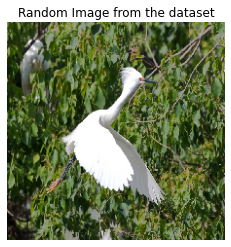

In [8]:
# Choose a random image from the dataset
random_class = os.listdir("inaturalist_12K/train")[np.random.randint(0, 10)]
random_class_images = os.listdir("inaturalist_12K/train/"+random_class)
random_image = random_class_images[np.random.randint(0, len(random_class_images))]

# Load the random image that we will use for guided backpropagation
img = tf.keras.preprocessing.image.load_img("inaturalist_12K/train/"+random_class+"/"+random_image,
                                            target_size=(224, 224))

# Display the random image
plt.imshow(img)
plt.axis("off")
plt.title("Random Image from the dataset")
plt.show()

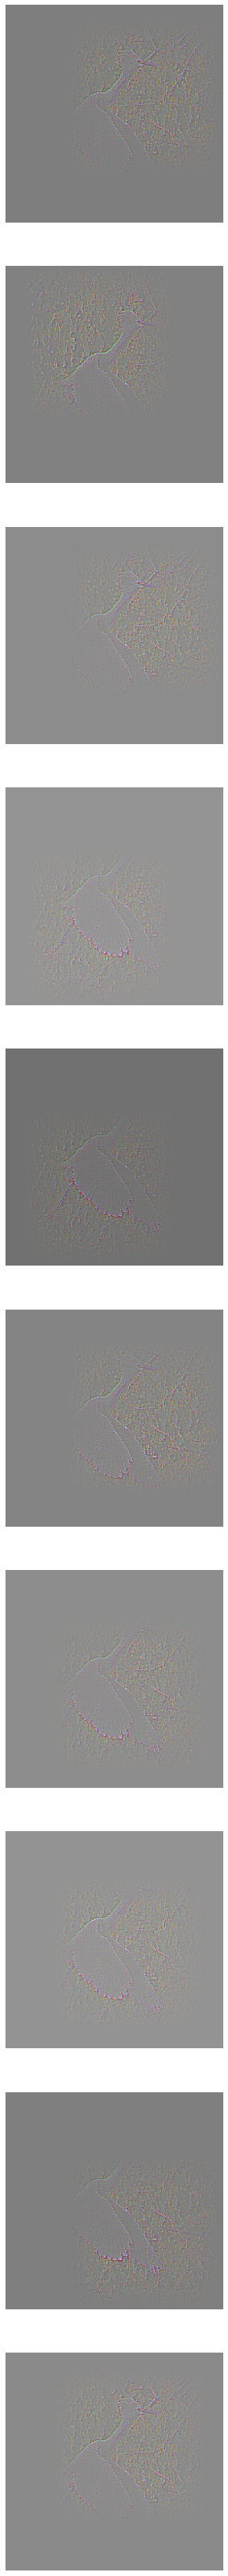

In [9]:
# This custom model has the 5th convolutional layer as its final layer
guided_backprop_model = tf.keras.models.Model(inputs = [model.inputs], outputs = [model.get_layer(index=-8).output])
# Here we choose only those layers that have an activation attribute
layer_dictionary = [layer for layer in guided_backprop_model.layers[1:] if hasattr(layer,'activation')]

# Define a custom gradient for the version of ReLU needed for guided backpropagation
@tf.custom_gradient
def guidedbackpropRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

for l in layer_dictionary:
    # Change the ReLU activation to supress the negative gradients
    if l.activation == tf.keras.activations.relu:
        l.activation = guidedbackpropRelu

# The shape of the layer that we are interested in
conv_output_shape = model.layers[-8].output.shape[1:]

plt.figure(figsize=(30, 60))
for i in range(10):
    # Index of a random pixel
    neuron_index_x = np.random.randint(0, conv_output_shape[0])
    neuron_index_y = np.random.randint(0, conv_output_shape[1])
    neuron_index_z = np.random.randint(0, conv_output_shape[2])

    # Mask to focus on the outputs of only one neuron in the last convolution layer
    masking_matrix = np.zeros((1, *conv_output_shape), dtype="float")
    masking_matrix[0, neuron_index_x, neuron_index_y, neuron_index_z] = 1

    # Calculate the gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.array([np.array(img)]), tf.float32)
        tape.watch(inputs)
        outputs = guided_backprop_model(inputs) * masking_matrix

    grads_visualize = tape.gradient(outputs, inputs)[0]

    # Visualize the output of guided backpropagation
    img_guided_bp = np.dstack((grads_visualize[:, :, 0], grads_visualize[:, :, 1], grads_visualize[:, :, 2],)) 

    # Scaling to 0-1      
    img_guided_bp = img_guided_bp - np.min(img_guided_bp)
    img_guided_bp /= img_guided_bp.max()
    plt.subplot(10, 1, i+1)
    plt.imshow(img_guided_bp)
    plt.axis("off")

plt.show()